In [12]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [3]:

# Define the tickers
tickers = ["SPY", "QQQ"]

end_date = datetime(2023, 12, 31)
start_date = end_date - timedelta(days=450)

# end_date = datetime.now()
# start_date = "2023-01-01"
# end_date = "2023-12-31"

# Download data as dataframe
SPY_data = yf.download(tickers[0], start=start_date, end=end_date).tail(300)
QQQ_data = yf.download(tickers[1], start=start_date, end=end_date).tail(300)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
SPY_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-20,368.029999,372.670013,364.609985,365.410004,358.294128,88283100
2022-10-21,365.119995,374.799988,363.540009,374.290009,367.001190,131038400
2022-10-24,375.890015,380.059998,373.109985,378.869995,371.491974,85436900
2022-10-25,378.790009,385.250000,378.670013,384.920013,377.424194,78846300
2022-10-26,381.619995,387.579987,381.350006,382.019989,374.580627,104087300


In [27]:
def plot_candlestick_graph(df, ticker):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])
    
    fig.update_layout(
        title=f'Timeseries {ticker}',
        yaxis_title='Price')

    fig.show()
    
def plot_timeseries(df, col, ticker):
    plt.figure(figsize=(8,4))
    plt.plot(df[col])
    plt.title(f'Price over Time: {ticker}', fontsize=12)
    plt.ylabel(f'Price', fontsize=12)
    # for year in range(df.index[0].year, df.index[-1].year):
    #     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    
plot_candlestick_graph(SPY_data, 'SPY')
plot_candlestick_graph(QQQ_data, 'QQQ')

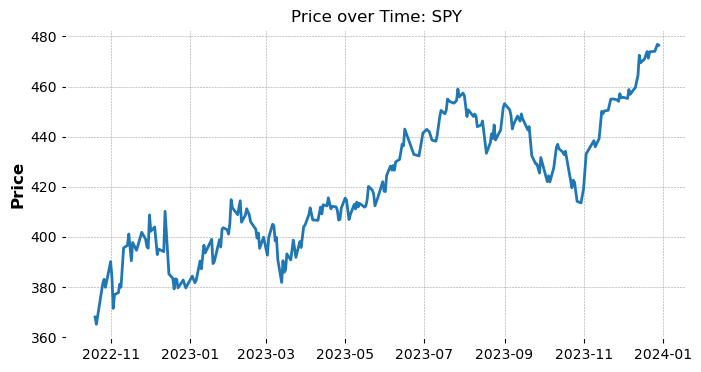

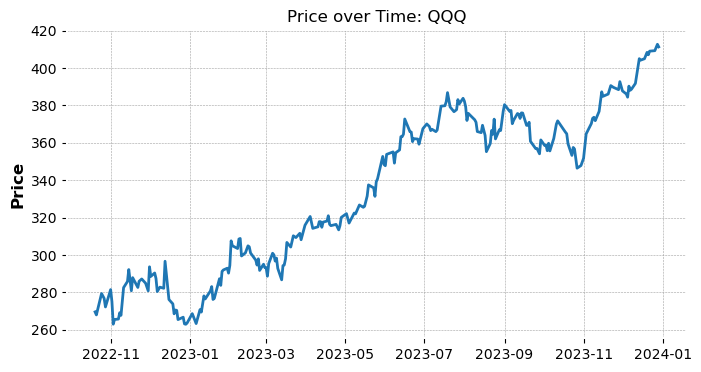

In [30]:
plot_timeseries(SPY_data, 'Open', 'SPY')
plot_timeseries(QQQ_data, 'Open', 'QQQ')